<a href="https://colab.research.google.com/github/AriannaRigamonti/MachineLearning/blob/main/MachineLearning_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df)

               Kingdom   DNAtype   SpeciesID   Ncodons    \
0         872  vrl              0      207343       6686   
1        9865  inv              0        7629      10060   
2        3190  bct              0      320850      14031   
3        3674  bct              0        1397      39839   
4       11372  vrt              1       50790       5112   
...       ...       ...       ...         ...        ...   
10417    7087  pln              0      332388       1791   
10418    2077  vrl              0      374598      68352   
10419    4497  bct              0      267998       2292   
10420    6491  pln              2      175050       1022   
10421    7246  pln              2       36012       1026   

      SpeciesName                                                           \
0      Bovine foamy virus                            ...                     
1      Anthocidaris crassispina                      ...                     
2      Staphylococcus phage X2               

PRE-PROCESSING

In [ ]:
# Remove extra spaces from column names
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# remove columns: SpeciesID, Ncodons, SpeciesName, AGA
columns_to_remove = ['SpeciesID', 'Ncodons', 'SpeciesName', 'AGA']
train = train_df.drop(columns_to_remove, axis = 1)
columns_to_remove2 = ['SpeciesID', 'Ncodons', 'SpeciesName']
test = test_df.drop(columns=columns_to_remove2)

# check if there are na values
nan_values = train.isna().sum().sum()
nan_values # no na values.
print(train)

       Unnamed: 0 Kingdom  DNAtype      UUU      UUC      UUA      UUG  \
0             872     vrl        0  0.01541  0.00927  0.01720  0.01825   
1            9865     inv        0  0.01213  0.02515  0.00268  0.01352   
2            3190     bct        0  0.02580  0.01618  0.03606  0.01354   
3            3674     bct        0  0.00128  0.02141  0.01225  0.01649   
4           11372     vrt        1  0.03169  0.01780  0.03893  0.00000   
...           ...     ...      ...      ...      ...      ...      ...   
10417        7087     pln        0  0.02289  0.02959  0.00614  0.02680   
10418        2077     vrl        0  0.02532  0.01557  0.00878  0.01185   
10419        4497     bct        0  0.01614  0.02618  0.00131  0.01003   
10420        6491     pln        2  0.00196  0.01761  0.04501  0.03131   
10421        7246     pln        2  0.01754  0.03704  0.01559  0.01852   

           CUU      CUC      CUA  ...      CGA      CGG      AGG      GAU  \
0      0.01436  0.02303  0.01555  

In [ ]:
def onehot_feature(pd_data, column_name):
    # Use pandas get_dummies to perform one-hot encoding
    one_hot_encoded = pd.get_dummies(pd_data[column_name], prefix=column_name)

    # Drop the original column
    pd_data = pd_data.drop(column_name, axis=1)

    # Concatenate the one-hot encoded columns to the original DataFrame
    pd_data = pd.concat([pd_data, one_hot_encoded], axis=1)

    return pd_data

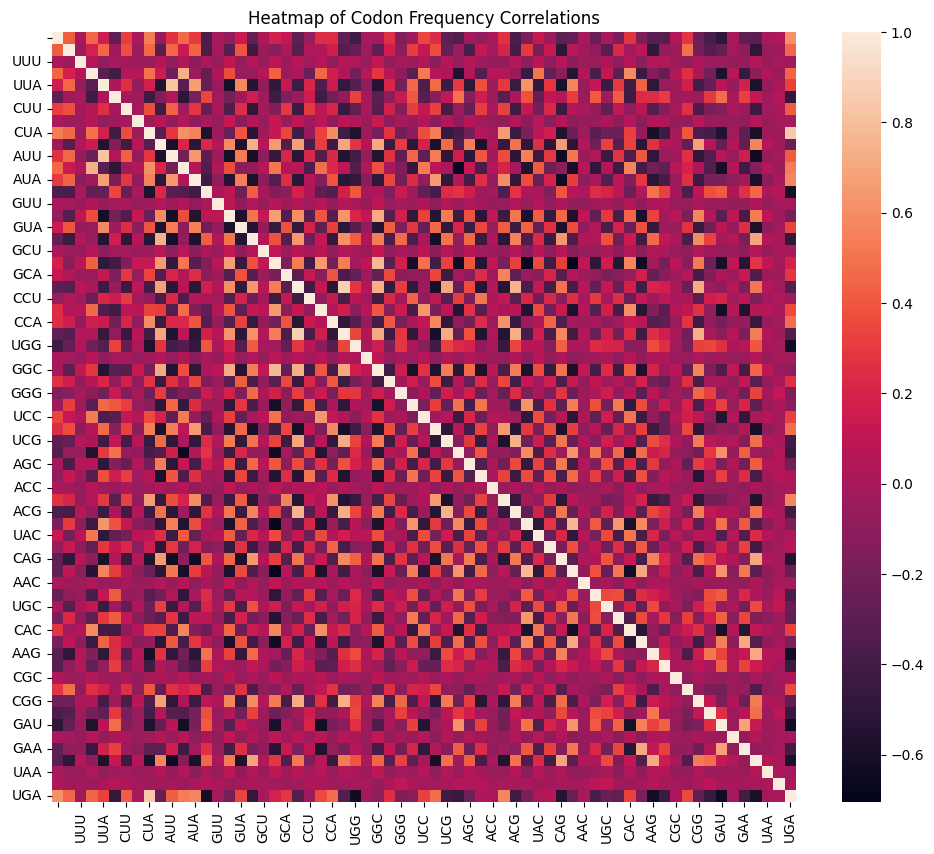

In [43]:
# Preliminary Data Analysis

# Select only numeric columns for correlation matrix
numeric_features = train.select_dtypes(include=[float, int]).columns

# Correlation Matrix
corr_matrix = train[numeric_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix)
plt.title('Heatmap of Codon Frequency Correlations')
plt.show()

In [57]:
# subset correlation matrix keeping only values > 0.7 and < -0.4
corr_matrix.head()
corr_max = corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.4)]
corr_max["count"] = corr_max.count(axis = 1)
corr_max2 = corr_max[corr_max["count"] > 1]
corr_max3 = corr_max2.drop(corr_max2.columns[~corr_max2.columns.isin(corr_max2.index)], axis = 1)

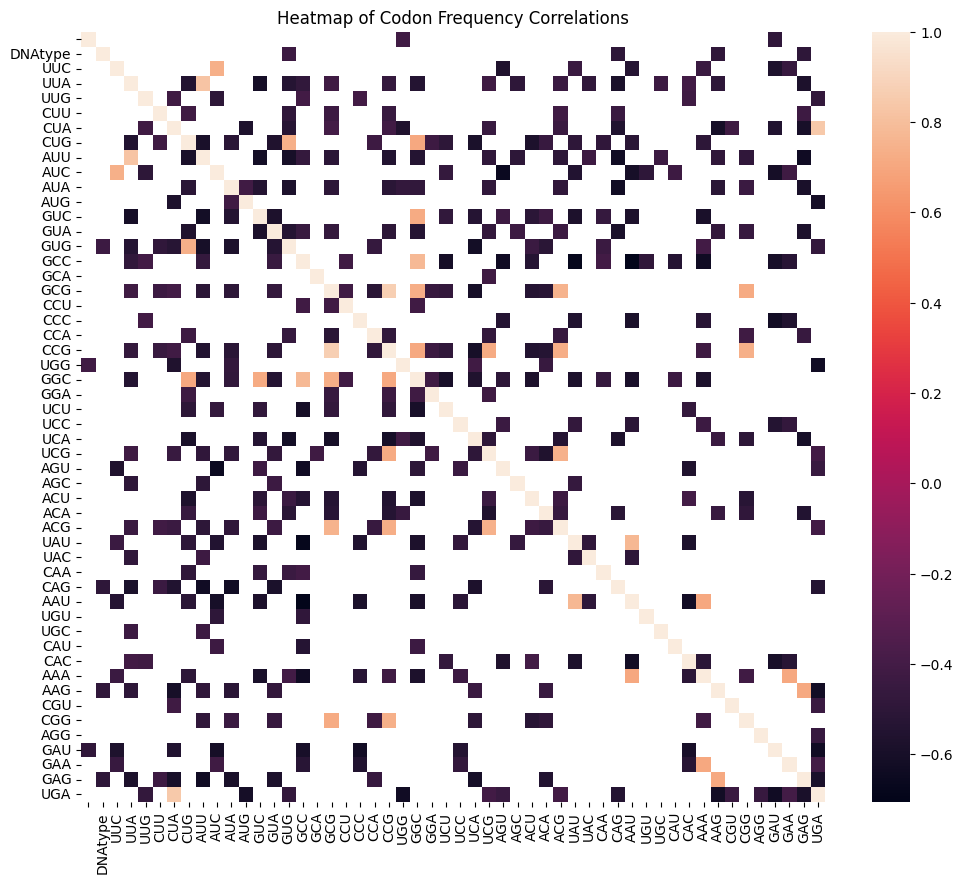

In [59]:
# Correlation Matrix on corr_max3
plt.figure(figsize=(12, 10))
sns.heatmap(corr_max3)
plt.title('Heatmap of Codon Frequency Correlations')
plt.show()

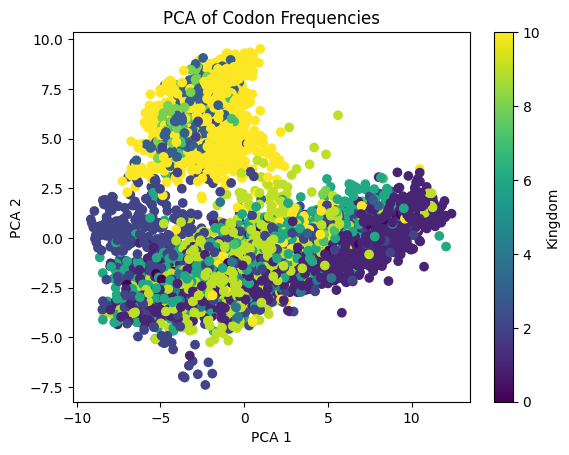

In [41]:
# Convert categorical values in "Kingdom" to numerical representations
train['Kingdom_code'] = pd.Categorical(train['Kingdom']).codes

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train.iloc[:, 3:])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Visualization of PCA results with color based on the numerical representation of "Kingdom"
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train['Kingdom_code'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Codon Frequencies')
plt.colorbar(label='Kingdom')
plt.show()

In [ ]:
# Convert categorical values in "Kingdom" to numerical representations
#train['Kingdom_code'] = pd.Categorical(train['Kingdom']).codes

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train.iloc[:, 3:])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Visualization of PCA results with color based on the numerical representation of "Kingdom"
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train['DNAtype'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Codon Frequencies')
plt.colorbar(label='DNAtype')
plt.show()

In [ ]:
# Clustering
kmeans = KMeans(n_clusters=11)
kmeans_labels = kmeans.fit_predict(scaled_features)
print(f'Silhouette Score for KMeans: {silhouette_score(scaled_features, kmeans_labels)}')

In [ ]:
# Classification
X = train_df.iloc[:, 3:]
y = train_df['Kingdom']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Random Forest Classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)
print(classification_report(y_val, y_pred))

In [ ]:
# Feature Selection using Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)
X_train_selected = model.transform(X_train)
X_val_selected = model.transform(X_val)

In [ ]:
# Train and Evaluate Classifier on Selected Features
rf_clf.fit(X_train_selected, y_train)
y_pred_selected = rf_clf.predict(X_val_selected)
print(classification_report(y_val, y_pred_selected))

In [ ]:
# Regression for AGA codon
X_train_reg = train_df.iloc[:, 3:].drop('AGA', axis=1)
y_train_reg = train_df['AGA']
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_reg, y_train_reg)

In [ ]:
# Predicting missing AGA values
X_test = test_df.iloc[:, 2:]
aga_pred = rf_reg.predict(X_test)
test_df['AGA'] = aga_pred

In [ ]:
# Re-training the classification model with predicted AGA values
X_test_full = test_df.iloc[:, 2:]
final_predictions = rf_clf.predict(X_test_full)

In [ ]:
# Save predictions
test_df['Predicted_Kingdom'] = final_predictions
test_df.to_csv('final_predictions.csv', index=False)